# Monthly Mean Historical Hydrologic Variables from LOCA and BCSD

This notebook analyzes hydrologic variables from the historical scenario (1950-2005) from the LOCA and BCSD datasets. Each dataset is compared to its respective analog simulation run using gridded observations -- Livneh observations for LOCA and Maurer observations for BCSD.

Variables include:
- Total Runoff
- ET

In [9]:
from loca import print_date
print_date()

Last executed: 2019-08-08 16:21:21.960930 by jvano on casper20


# Imports and Options

In [23]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt


import xarray as xr

from loca.data_catalog import load_monthly_historical_hydro_datasets, load_monthly_cmip_hydro_datasets, resample_monthly_data
from loca.utils import calc_change
from loca.plot import make_plot, PROJECTION

# models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1'] #5 models currently using
# models = ['ACCESS1-0', 'CanESM2']
#models = ['CCSM4', 'CNRM-CM5']

# list of 20, without issues
# models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1', 'bcc-csm1-1-m', 'CCSM4', 'CESM1-BGC', 'CMCC-CM', 'GISS-E2-R', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-MR', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M', 'GFDL-ESM2G']
# models = ['ACCESS1-0', 'CanESM2','MIROC5', 'MRI-CGCM3']
models = ['ACCESS1-0', 'CanESM2']

#cache is written in script xxx (TODO need to move it to its own script)
read_cache = True
# cache_dir = os.environ['TMPDIR']
cache_dir = '/glade/u/home/jvano/scratch/'


hydro_vars = ['ET', 'total_runoff', 'SWE']
kwargs = {'ET': {'vmin': 0, 'vmax': 1000},
          'total_runoff': {'vmin': 0, 'vmax': 1000}, 'SWE': {'vmin': 0, 'vmax': 100},}
units = {'ET': 'mm', 'total_runoff': 'mm', 'SWE': 'mm'}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from dask.distributed import Client
client = Client(scheduler_file=os.path.join(os.environ['HOME'], 'scheduler_file.json'))
client

<Client: scheduler='tcp://128.117.181.226:33817' processes=2 cores=4>

In [25]:
cache_dir

'/glade/u/home/jvano/scratch/'

# Load Data

In [26]:
hist_cmip_data = {}
if read_cache:
    print("reading values from cache")
    for key in ['loca', 'bcsd']:
        hist_cmip_data[key] = xr.open_mfdataset(
            os.path.join(cache_dir, f'monthly_cmip_hydro_hist.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
    print("finished reading from cache")
    ds = hist_cmip_data['loca']
    print(ds['total_runoff'])
    #TODO once get obs load separate won't have to do work around below
    single = ['ACCESS1-0']
    obs_data = load_monthly_historical_hydro_datasets(models=single, autoclose=True, parallel=True)
    #obs_data = load_monthly_historical_hydro_datasets(single, autoclose=True, parallel=True) #appears to work without "models"
    print("finished reading obs")

else:
    print("reading values from files directly")
    hydro_data = load_monthly_historical_hydro_datasets(models=models, autoclose=True, parallel=True)

reading values from cache
finished reading from cache
<xarray.DataArray 'total_runoff' (gcm: 25, time: 672, lat: 224, lon: 464)>
dask.array<shape=(25, 672, 224, 464), dtype=float32, chunksize=(1, 72, 224, 464)>
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2005-12-01
  * lat      (lat) float64 25.06 25.19 25.31 25.44 ... 52.56 52.69 52.81 52.94
  * lon      (lon) float64 -124.9 -124.8 -124.7 -124.6 ... -67.31 -67.19 -67.06
  * gcm      (gcm) <U14 'ACCESS1-0' 'CCSM4' ... 'bcc-csm1-1' 'inmcm4'
load_monthly_historical_hydro_datasets
load_monthly_cmip_hydro_datasets
load_monthly_loca_hydrology
load_daily_loca_hydrology
load_monthly_bcsd_hydrology
load_bcsd_dataset
load_monthly_livneh_hydrology
load_daily_livneh_hydrology
load_monthly_maurer_hydrology
finished reading obs


In [10]:
# list(hydro_data.keys())
# list(hist_cmip_data.keys())

#TODO:  at some point I'd like to just create load that only loads obs 
#hydro_test = load_monthly_obs_hydro_datasets(models=models, autoclose=True, parallel=True)

# Merge two.  Wouldn't have to do this
x = obs_data
y = hist_cmip_data
hydro_data = {**x, **y}

#list(hydro_data.keys())
#print(hydro_data)
#hist_data
#hist_data['loca']['ET'].mean('gcm')
#hist_data.items()

NameError: name 'obs_data' is not defined

In [5]:
epoch = slice('1969-10-01', '1999-09-30')

mask = hydro_data['bcsd']['total_runoff'].isel(gcm=0, time=0).squeeze().notnull()

epoch_means = dict((k, ds.sel(time=epoch).mean('time').where(mask).persist())
                   for (k, ds) in hydro_data.items())
epoch_means = dict((k, resample_monthly_data(ds.sel(time=epoch), freq='AS', chunks={'lat': 100, 'lon': 100}).mean('time').where(mask).persist()) for (k, ds) in hydro_data.items())

ens_means = dict((k, resample_monthly_data(ds.sel(time=epoch), freq='AS', chunks={'lat': 100, 'lon': 100}).mean('time').mean('gcm').where(mask).persist()) for (k, ds) in hist_cmip_data.items())

# for debugging
# epoch_means = {}
# for k, ds in hydro_data.items():
#     print(k, flush=True)
#     epoch_means[k] = ds.sel(time=epoch).mean('time').where(mask).compute()

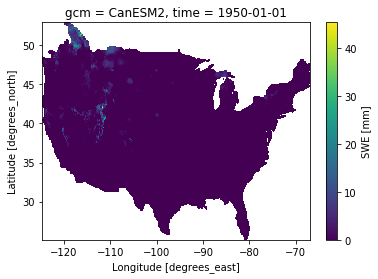

In [7]:
hydro_data['bcsd']['SWE'].isel(gcm=1, time=0 ).plot()

# ASK JOE - HOW JUST PLOT A SINGLE MONTH.  Is it a groupby function or is there something easier?

In [ ]:
monthly = hydro_data['bcsd']['SWE'].groupby('time.month').mean('time').load()

In [ ]:
monthly

In [17]:
hydro_data['bcsd']['SWE']['time.month']


<xarray.DataArray 'month' (time: 672)>
array([ 1,  2,  3, ..., 10, 11, 12])
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2005-12-01

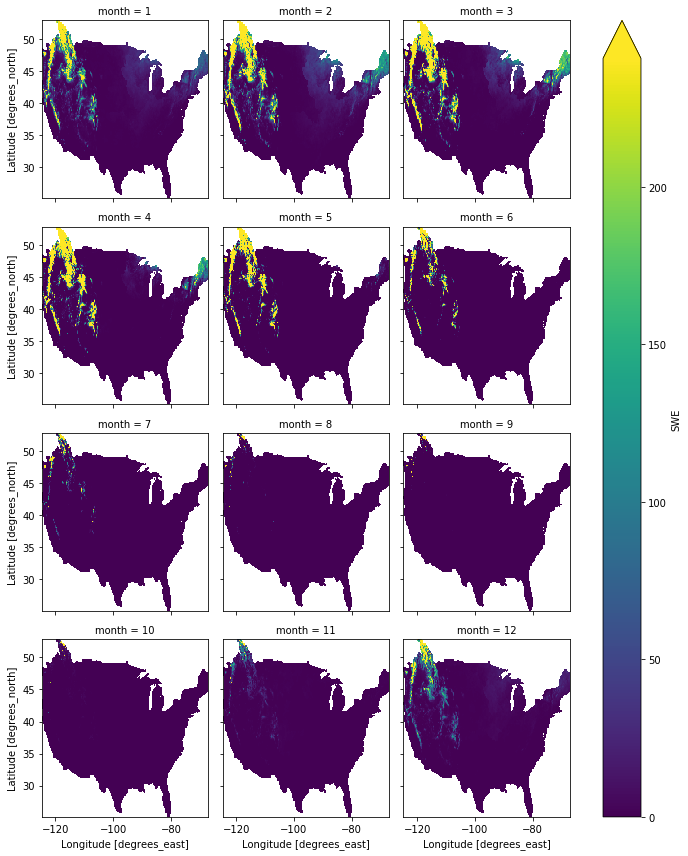

In [23]:
monthly.plot(col='month',col_wrap=3,robust=True)

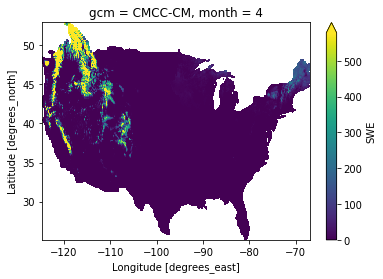

In [24]:
monthly.sel(month=4).plot(robust=True)

# Plots

For the monthly hydrologic variables, we will make 2 types of plots:

1. Maps of all datasets plotted as actual values (epoch, seasonal, and monthly means)
2. Maps of all datasets with LOCA and BCSD datasets plotted as biases relative to observation based VIC simulations (epoch, seasonal, and monthly means)

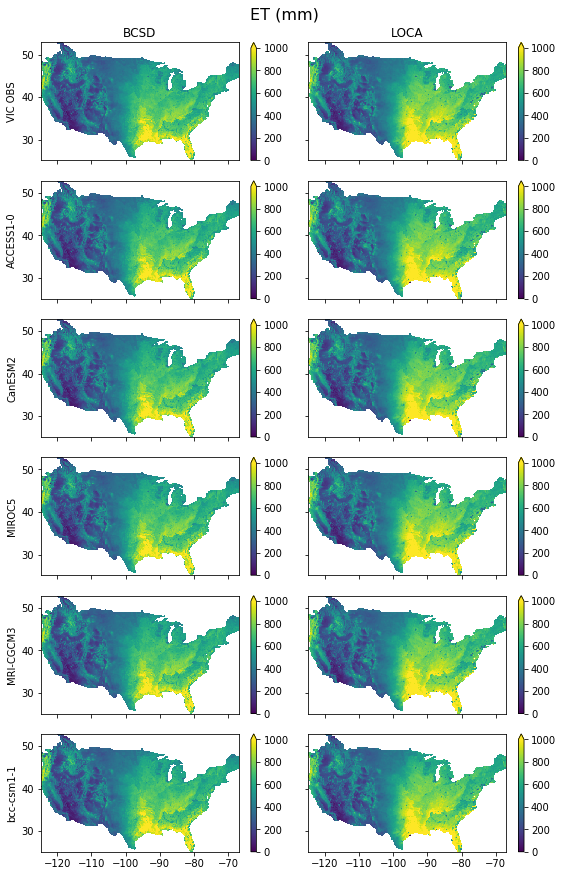

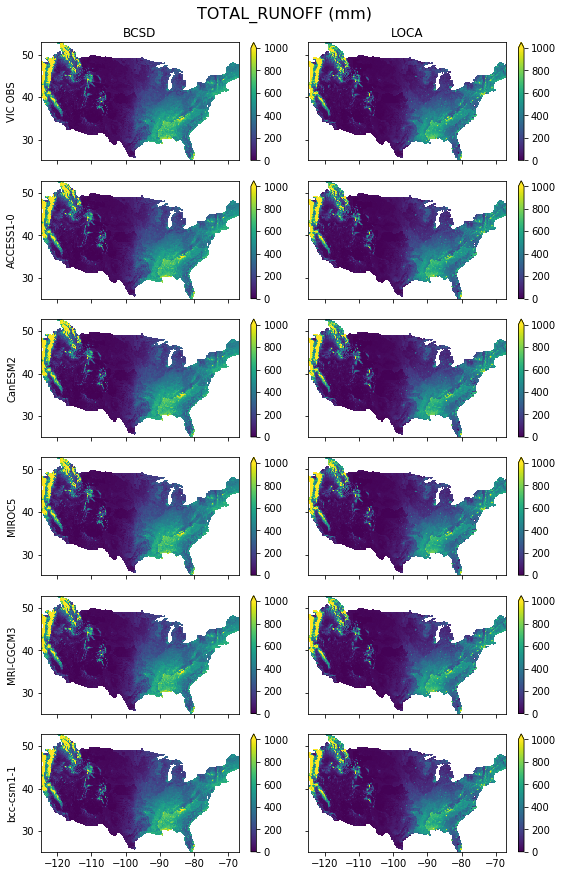

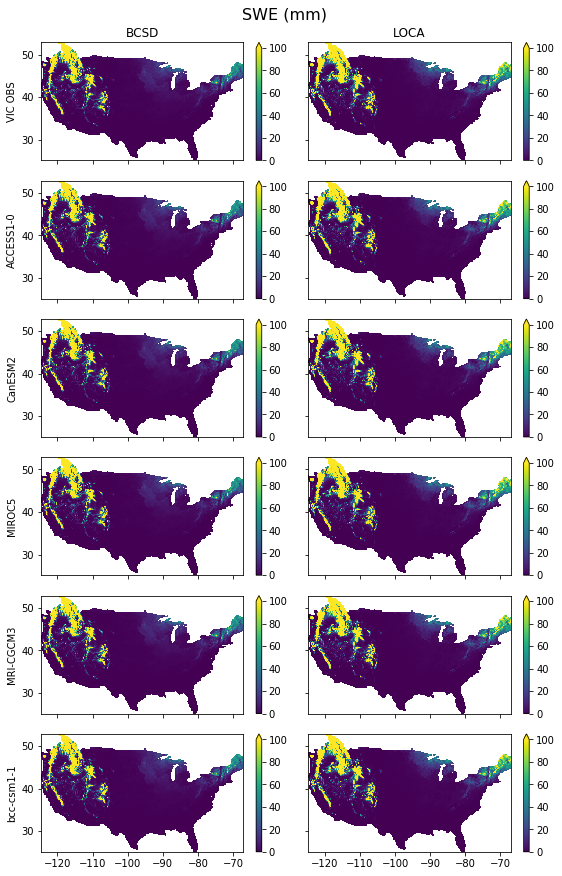

In [21]:
#OLDER VERSION WITHOUT ENSEMBLE AVG
kwargs = {'ET': {'vmin': 0, 'vmax': 1000},
          'total_runoff': {'vmin': 0, 'vmax': 1000}, 'SWE': {'vmin': 0, 'vmax': 1000},}
units = {'ET': 'mm', 'total_runoff': 'mm', 'SWE': 'mm'}

nrows = 1 + len(models)
ncols = 2

for var in hydro_vars:
    
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(4*ncols, 2*nrows))
    
    for col, (title, obs_data, ds_data) in enumerate([('BCSD', epoch_means['maurer'], epoch_means['bcsd']),
                                                      ('LOCA', epoch_means['livneh'], epoch_means['loca'])]):
        
        ax = axes[0, col]
        obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
        
        if col == 0:
            ax.set_ylabel('VIC OBS')
        
        ax.set_title(title)
        
        for row, model in enumerate(models, 1):
            ax = axes[row, col]
#             ds_data[var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
            obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
            
            if col == 0:
                ax.set_ylabel(model)
                
    title = var.upper()
    title += ' (%s)' % units[var]
    unit_str = units[var]
    fig.suptitle(title, fontsize=16, y=1.01)
    fig.tight_layout()     
    fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/{var}_{unit_str}_monthly_historic_hydro_30WYs.png', dpi=300, bbox_inches='tight')

In [47]:
#ens_means['bcsd'].mean('gcm')
#hist_means['loca']['total_runoff'].mean('gcm') --> doesn't work

#ens_means['bcsd']
#epoch_means['maurer']
#epoch_means['livneh']

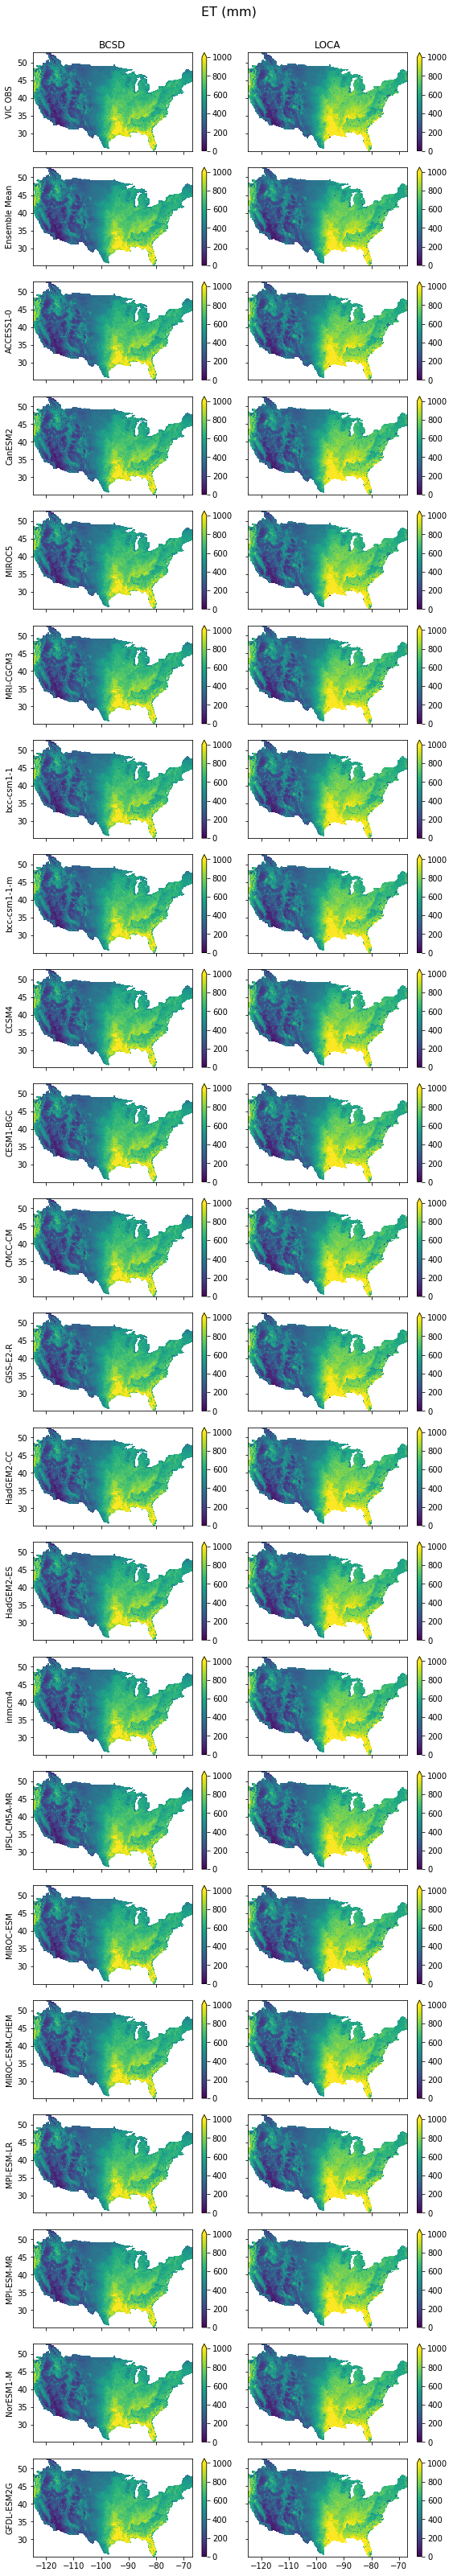

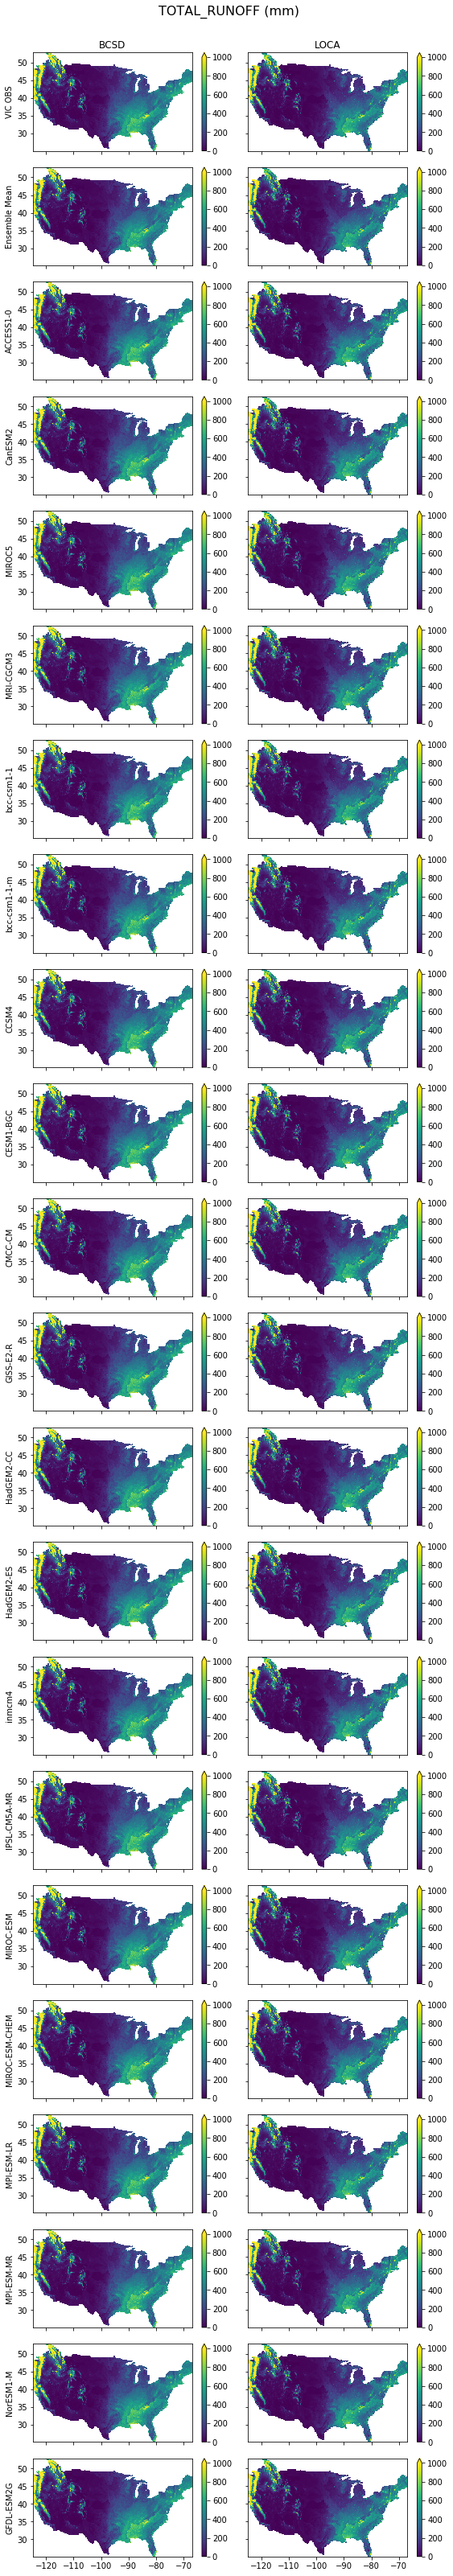

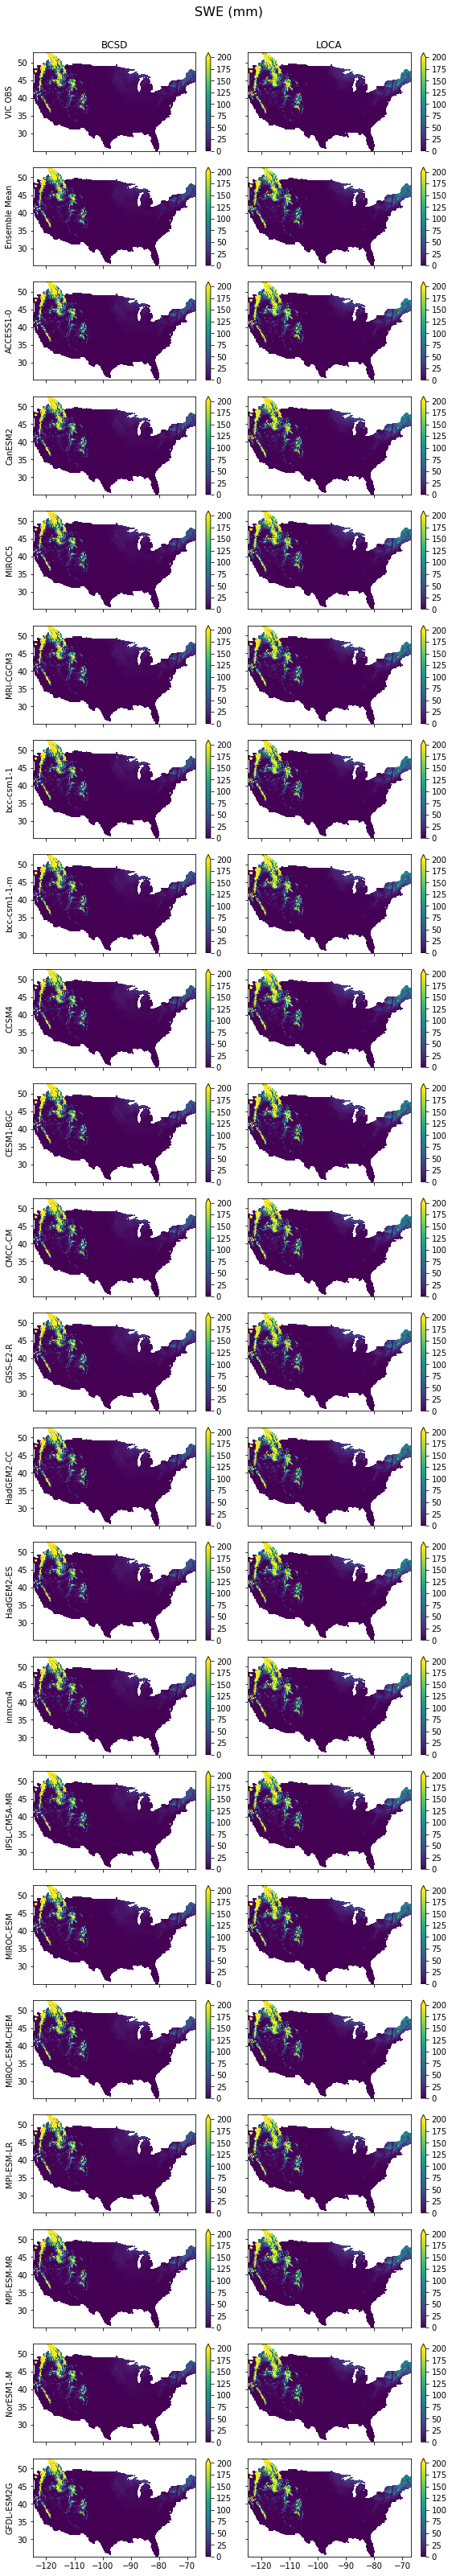

In [14]:
# NEW:  Ensemble added
hydro_vars = ['ET', 'total_runoff', 'SWE']
# hydro_vars = ['SWE']


# kwargs = {'ET': {'vmin': 0, 'vmax': 1000},
#           'total_runoff': {'vmin': 0, 'vmax': 1000},}
# units = {'ET': 'mm', 'total_runoff': 'mm'}


kwargs = {'ET': {'vmin': 0, 'vmax': 1000},
          'total_runoff': {'vmin': 0, 'vmax': 1000}, 'SWE': {'vmin': 0, 'vmax': 200},}
units = {'ET': 'mm', 'total_runoff': 'mm', 'SWE': 'mm'}

nrows = 2 + len(models)
ncols = 2

for var in hydro_vars:
    
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(4*ncols, 2*nrows))
    
    for col, (title, obs_data, ensemble, ds_data) in enumerate([('BCSD', epoch_means['maurer'], ens_means['bcsd'], epoch_means['bcsd']),
                                                      ('LOCA', epoch_means['livneh'], ens_means['loca'], epoch_means['loca'])]):
        
        ax = axes[0, col]
        obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
        ax.set_title(title)
        
        if col == 0:
            ax.set_ylabel('VIC OBS')
            
        ax = axes[1, col]
        ensemble[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
        
                
        if col == 0:
            ax.set_ylabel('Ensemble Mean')

        
        for row, model in enumerate(models, 2):
            ax = axes[row, col]
#             ds_data[var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
            obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])

            
            if col == 0:
                ax.set_ylabel(model)
                
    title = var.upper()
    title += ' (%s)' % units[var]
    unit_str = units[var]
    fig.suptitle(title, fontsize=16, y=1.01)
    fig.tight_layout()     
    fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/{var}_{unit_str}_monthly_historic_hydro_30WYs.png', dpi=300, bbox_inches='tight')

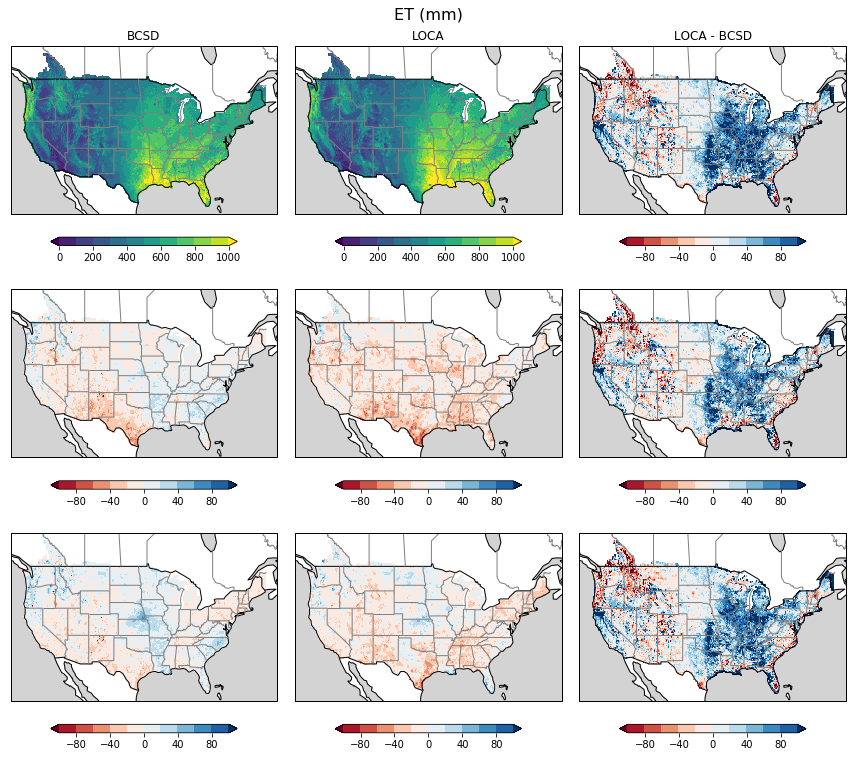

In [29]:
# JJH: added entries to kwargs
style_kwargs =  {'levels': 11, 'extend': 'both', 'add_labels': False, 'cbar_kwargs': dict(orientation="horizontal", shrink=0.7, pad=0.1)}
kwargs = {'ET': {'vmin': 0, 'vmax': 1000, **style_kwargs},
          'total_runoff': {'vmin': 0, 'vmax': 1000, **style_kwargs},
          'SWE': {'vmin': 0, 'vmax': 1000, **style_kwargs},}


# dict(cbar_kwargs=dict(orientation="horizontal", shrink=0.7),
#               levels=np.arange(-10, 11, 2),
#               extend='both',
#               add_labels=False)

diff_kws = {False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', **style_kwargs},
                    'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', **style_kwargs},
                    'SWE': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', **style_kwargs},},
            True: {'ET': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', **style_kwargs},
                   'total_runoff': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', **style_kwargs},
                   'SWE': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', **style_kwargs}}}

nrows = 1 + len(models)
ncols = 2

# hydro_vars = ['ET', 'total_runoff']
hydro_vars = ['ET']
for var in hydro_vars:
    
#     for pct in [False, True]:
    for pct in [False]:
        
        if var not in diff_kws[pct]:
            continue
    
#         fig, axes = plt.subplots(ncols=ncols + 1, nrows=nrows, sharex=True, sharey=True, figsize=(4*ncols, 2*nrows))
        fig, axes = plt.subplots(ncols=ncols + 1, nrows=nrows, sharex=True, sharey=True, figsize=(12, 3.5*nrows), subplot_kw={'projection': PROJECTION})
#         fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(4*ncols, 2*nrows))
        
        

        for col, (title, obs_data, ds_data) in enumerate([('BCSD', epoch_means['maurer'], epoch_means['bcsd']),
                                                          ('LOCA', epoch_means['livneh'], epoch_means['loca'])]):

            ax = axes[0, col]
            make_plot(obs_data[var], ax=ax, plot_kwargs=kwargs[var])  # JJH - added this line
#             obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])

            if col == 0:
                ax.set_ylabel('VIC OBS')

            ax.set_title(title)
    
            diff = calc_change(obs_data[var], ds_data[var], pct=pct).persist()
            for row, model in enumerate(models, 1):
                ax = axes[row, col]
#                 diff.sel(gcm=model).plot.pcolormesh(ax=ax, **diff_kws[pct][var])
                make_plot(diff.sel(gcm=model), ax=ax, plot_kwargs=diff_kws[pct][var])  # JJH - added this line


                if col == 0:
                    ax.set_ylabel(model)

        ax = axes[0, -1]
        diff = calc_change(epoch_means['maurer'][var], epoch_means['livneh'][var], pct=pct)
#         diff.plot.pcolormesh(ax=ax, **diff_kws[pct][var])
        make_plot(diff, ax=ax, plot_kwargs=diff_kws[pct][var])  # JJH - added this line
        ax.set_title('LOCA - BCSD')

        diff = calc_change(epoch_means['bcsd'][var], epoch_means['loca'][var], pct=pct).persist()
        for row, model in enumerate(models, 1):
            ax = axes[row, -1]
#             diff.sel(gcm=model).plot.pcolormesh(ax=ax, **diff_kws[pct][var])
            make_plot(diff.sel(gcm=model), ax=ax, plot_kwargs=diff_kws[pct][var])  # JJH - added this line

            
        title = var.upper()
        title += ' (%s)' % units[var]
        if pct:
            title += ' (%)'
            unit_str = 'pct'
        else:
            unit_str = units[var]
        fig.suptitle(title, fontsize=16, y=1.01)
        fig.tight_layout()  
#         fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/diff_{var}_{unit_str}_monthly_historic_hydro_30WYs.png', dpi=300, bbox_inches='tight')

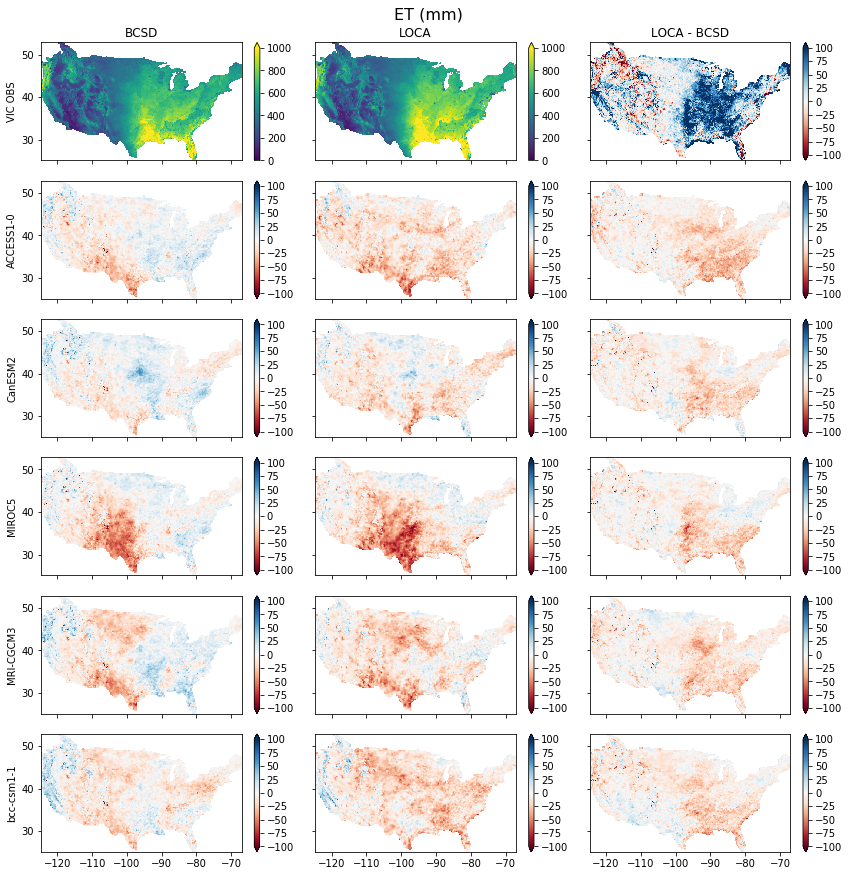

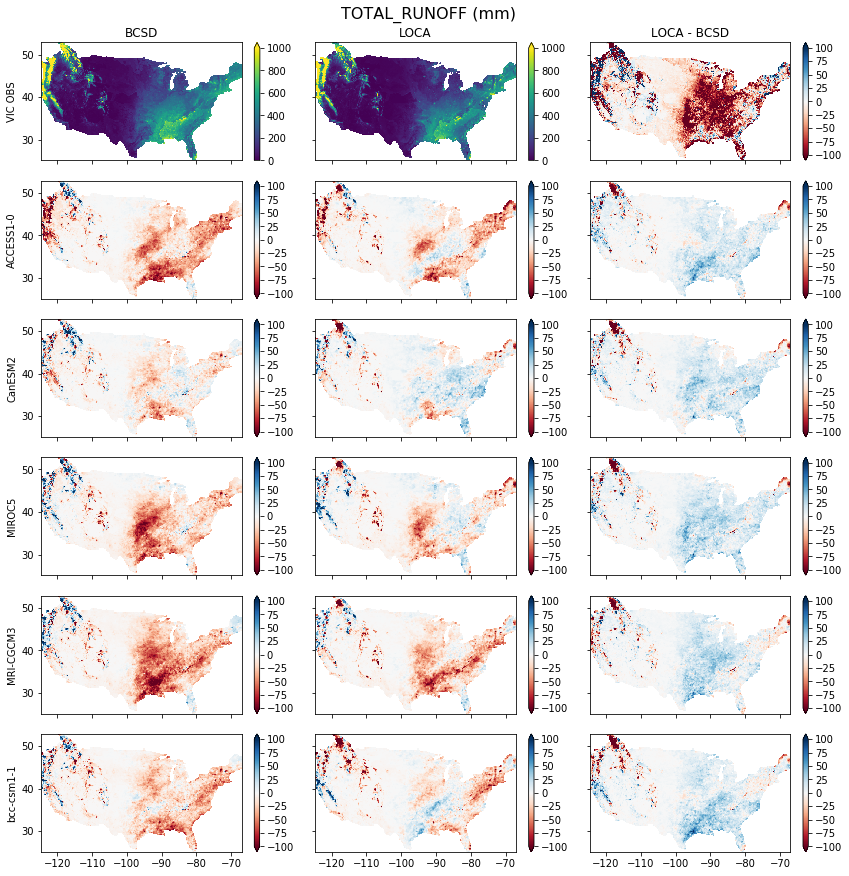

In [9]:
# IS DIFF OF DIFF plot, not currently using

diff_kws = {False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}, 'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}},
            True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'}, 'total_runoff': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'}}}

cache = {}

for var in hydro_vars:
    
    for pct in [False]:
        
        if var not in diff_kws[pct]:
            continue
    
        fig, axes = plt.subplots(ncols=ncols + 1, nrows=nrows, sharex=True, sharey=True, figsize=(12, 2*nrows))

        for col, (title, obs_data, ds_data) in enumerate([('BCSD', epoch_means['maurer'], epoch_means['bcsd']),
                                                          ('LOCA', epoch_means['livneh'], epoch_means['loca'])]):

            ax = axes[0, col]
            obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])

            if col == 0:
                ax.set_ylabel('VIC OBS')

            ax.set_title(title)
    
            diff = calc_change(obs_data[var], ds_data[var], pct=pct).persist()
            for row, model in enumerate(models, 1):
                ax = axes[row, col]
                diff.sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
                cache[(row, col)] = diff.sel(gcm=model)
                if col == 0:
                    ax.set_ylabel(model)

        ax = axes[0, -1]
        calc_change(epoch_means['maurer'][var], epoch_means['livneh'][var], pct=pct).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
        ax.set_title('LOCA - BCSD')

        for row, model in enumerate(models, 1):
            ax = axes[row, -1]
            diff = cache[(row, 1)] - cache[(row, 0)]  #DIFF OF A DIFF JAV, right?
            diff.plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])

            
        title = var.upper()
        title += ' (%s)' % units[var]
        if pct:
            title += ' (%)'
            unit_str = 'pct'
        else:
            unit_str = units[var]
        fig.suptitle(title, fontsize=16, y=1.01)
        fig.tight_layout()  
        fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/diff2_{var}_{unit_str}_monthly_historic_hydro_30WYs.png', dpi=300, bbox_inches='tight')

In [ ]:
# cleanup 
plt.close('all')

In [ ]:
print('done now okay')